# Voting and Auditing with Ternary Plurality Trees

## by Ronald L. Rivest

### August 23, 2019

#### Abstract

We suggest using "_ternary plurality trees_" to define a voting method (called TPT). 
TPT voting is quite close to, but different than, plurality voting; we examine how close TPT and plurality are.

Perhaps the most interesting aspects of TPT voting have to do with auditing.  Auditing a TPT contest is __combinatorial__ in character rather than __statistical__ (as with a risk-limiting audit).  With TPT voting an election contest with $3^d$ cast ballots can be audited in a _zero-risk_ manner by manually examining only $2^d$ cast paper ballots, in the case of two candidates, with no missing or invalid ballots.  For example, a two-candidate contest with one million cast paper ballots may be audited by examining only 6104 ballots, assuming no interpretation errors are found in the audit.

The $n$ cast ballots are arranged as the leaves in a ternary tree of height $\log_3(n)$.
Each internal node of the tree has a value equal to the plurality vote of its three children (with ties broken pseudorandomly).
The value at the root is the winner of the contest, by definition.
Auditing the contest outcome requires examining only two of every three children of audited nodes (assuming two candidates and no discrepancies discovered).

The TPT voting method is quite close to, but different than, plurality voting; we 
examine how close TPT and plurality are.

The outcome of a TPT election may depend on the way in which ballots are assigned to
leaves of the tree.  TPT assigns ballots to leaves in a randomized manner to ensure 
that all voters may expect an equal voice in the outcome.

We present the result of a simple experiment illustrating how auditing a TPT election expands gracefully when interpretation errors are found.

Finally, we show how the TPT method extends to handle multiple candidates
and ballots with missing or invalid choices.


** Motivating example **

We begin with a quick example that illustrates many of the key ideas.

Imagine that we have an election with nine voters, each voting for one of two candidates, A or B. The first voter votes for B, the second for A, and so on.

We arrange the nine votes as the leaves of a ternary tree of depth two, shown as labelled square boxes in the figure below.  The voter's number is shown below each leaf.

There are four internal nodes, drawn as circles: the root at the top at level 0, and three internal nodes at level 1 which are its children.  Each level-1 node has three leaves as its children.

The winner of the contest is computed on this tree in a bottom-up manner.  Each leaf has a value that is the that voter's choice.  Each internal node has a value that is the plurality of the values of its children.  (With only two candidates and a ternary tree, plurality is the same as majority.)

The value at the root is the winner of the contest.  In this case, candidate B is the winner.

In [1]:
# need to run notebook twice to get draw_tree and contest defined here
try
    draw_tree(contest)
catch
end

To audit this election, we consider the subtree that determined the winning value (at the root).  By construction, the value at any node can be confirmed by confirming the values at exactly two of its children.  Recursively this yields a binary tree that is a subtree of the ternary tabulation tree; this binary tree is shown in bold in the above figure.  We see that auditing exactly **four** of the leaves suffices to confirm that the election outcome is correct.  Note that (unlike RLAs) a TPT audit only examines ballots that are reported to be votes for the reported winner.


# Introduction and Notation

Voting is a central feature of democratic countries and many organizations;
running elections is an essential operation.

There are a dazzling array of voting methods that have been studied and used in practice;
see 
__[Wikipedia page on electoral systems](https://en.wikipedia.org/wiki/Electoral_system)__.

The security of election systems has become an increasing concern.
See for example the recent NASEM report
__[Securing The Vote](https://www.nap.edu/catalog/25120/securing-the-vote-protecting-american-democracy)__, which recommends the use of paper ballots and post-election audits. An election outcome can be audited by manually examining a random sample of the cast paper ballots to provide confidence that the election outcome was correctly tabulated (computed correctly from the cast paper ballots).

Today, most post-election audits are statistical in character.  They are __risk-limiting audits__ that control the chance (risk) that an incorrect outcome would be accepted by the audit.  Such audits sample an increasing number of cast paper ballots at random until the risk of accepting an incorrect outcome is determined to be less than a pre-specified risk limit.
See 
__[A Gentle Introduction to Risk-Limiting Audits](https://www.stat.berkeley.edu/~stark/Preprints/gentle12.pdf)__ for more detail.

Risk-limiting audits (RLAs) are a wonderful invention and can be highly recommended.  They have the following potential drawbacks, however:
- the number of ballots examined is a random variable that depends on the "luck of the draw" when selecting ballots to be examined by hand
- a RLA may need to examine all of the cast paper ballots in the worst case (when there is a near-tie), even if the tabulation is correct,
- risk-limiting audits are known only for some voting methods; for other methods devising an appropriate RLA remains an open research question.  (But RLAs are known for the most common voting methods.)

The current note attempts to answer the question: 
> "Are there any voting methods that are similar to plurality (the most common voting method), but which are more **audit-friendly** (in terms of having a predictable and bounded audit workload)?"

We suggest such a voting method, called TPT (the Ternary Plurality Tree method) that behaves very much like plurality voting, but which has much better auditing properties---that is, much more predictable audit workload (at least for two-candidate contests) and
a much smaller worst-case workload.

This note thus begins a search for new voting methods that are well-behaved from a political science point of view and which support highly efficient audits, even in the worst case.  

## Notation

We assume an election with a single contest.
We discuss later elections with multiple contests, but TPT does not provide much economy of scale for audits of multiple contests.

We let $m$ denote the number of candidates (possible outcomes) in the contest.  We begin by examining the case of two candidates $(m=2)$. We let $C$ denote the set of $m$ candidates.

We assume that the contest outcome is always one of the eligible candidates.

We let $n$ denote the number of cast paper ballots.
    
Each cast paper ballot specifies a vote for exactly one of the $m$ candidates.
We do not consider voting by ranking or scoring the candidates.

We let $x = (x_1, x_2, \ldots, x_n)$ denote the list of votes cast; each $x_i$ is an element of $C$.

Later on, we shall also allow a ballot to say "missing" to denote a ballot left blank or a ballot with an invalid vote.  
Although we may allow $C$ to contain the value "missing", the value "missing" is special in that it is ineligible to win the contest; it can not win the contest unless **all** cast votes are "missing".


# Winner determination rules

A _winner determination rule_ $f$ (also commonly known as a _social choice function_) takes as input

- a list $x = (x_1, x_2, \ldots, x_n)$ of votes; each $x_i$ a vote for exactly one member of the set $C$ of $m$ candidates, 
- a randomization seed $r$

and produces as output a _winner_ (or _contest outcome_) $f(x, r)$ (also denoted $f_r(x)$),
which is also a member of $C$.

While the inclusion of the randomization seed $r$ may seem unusual, it is in fact typical for winner determination rules to use randomization to break ties and the like.  We assume that $f$ is otherwise deterministic; any randomization it uses is based on the seed $r$
(which might, say, be a 20-digit or a 256-bit randomly chosen value).

The winner determination function should have certain properties:

- **Unanimity**: For any $a\in C$ and any $r$ if $x=(a,a,...,a)$ the value  $f(x,r)=a$.

- **Monotonicity**: For any $r$, the function $f$ is __monotone__: 
  for any $x$ if $f(x,r)=a$ and $x_i\ne a$, then changing $x_i$ to $a$ will not
  change the output of $f$ to any outcome other than $a$.

- **Neutrality**: All outcomes are treated equally.

- **Anonymity**: All votes are treated equally.

- **Sensitivity**: For any fixed $r$ and any $i$, the function $f_r(x)$ should 
  depend on $x_i$.

One can interpret the anonymity criterion as saying that 
for any $r$, the function $f_r(x)$
is invariant under permutations of the elements of $x$, such permutations
belonging to a transitive permutation group.
(In practice for TPT, this is obtained not by such
an invariance, but by randomizing the order of the elements of $x$ before applying
the TPT outcome rule.)

Similarly, neutrality may be interpreted as saying that renaming all votes in a consistent way causes the winner to be renamed in the same way.

# TPT winner determination

This section describes the TPT method of computing a contest winner.

A key component of the TPT method is computing the plurality winner of
a small group (typically of size 3, but sometimes 2 or 4) of votes.  

This may be easy to do, such as when finding the winner among three votes, each
of which is for one of two candidates.

In other cases, when there are more than two candidates or when the size of the group is not three, a tie may ensue.  We resolve any such ties pseudorandomly, using
a master random seed and a number unique to that particular group.  (To ensure
neutrality, the random selection is based on picking one of the relevant votes
randomly, rather than by trying to directly pick one of the relevant outcomes randomly.
Perhaps a small point, but worth noting.)

In any case, the small group of votes is then represented by (replaced by) its
plurality winner.  

This process of computing a plurality winner for a small group can be iterated
to determine the TPT winner of the entire collection of votes.  

We describe two such methods; they are equivalent when $n$ is a power of three.

**Method 1 (Grouping by threes)**

We describe the GBT method for computing a
winner given $n$ votes, where $n>1$.  This is not our recommended
method, but has some utility for its intuitive content, and the fact
the GBT is the same as TPT when $n$ is a power of three.

1. Arrange the $n$ votes into a list.  

2. Permute this list pseudorandomly based on a random seed.

3. Group the votes by threes: ballots 1,2,3 form the first group of three, ballots 4,5,6 form form the second group of three, and so on.  If the number of votes is not a multiple of three, finish the grouping with one differently-sized last group (of size 2 or 4) as necessary so that each vote is in exactly one group.

4. Replace each group of (usually three) ballots by the plurality winner for the ballots in that group.  
This operation reduces the length of the list by a factor of
approximately three.

5. If the list now has length one, the vote remaining is for the winner, by
definition.  Otherwise return to step 3 and continue.

**Method 2 (Ternary plurality tree)**

Our second (and recommended) method of computing a TPT winner
is based on a heap-like representation of a ternary tree with an array.

A ternary tree has a number of nodes, some of which are _internal nodes_ and
some of which are _leaves_.  A leaf has no children, while an internal node
has two or three children.  A single root node is at the top of the tree.  Each
internal node is the root of a ternary subtree.  The above figure illustrates a
ternary tree having $n=9$ leaves.

The number of internal nodes is $\underline{ni} = (n-1)/(k-1)$, rounded up as necessary, where $k=3$ is the arity of the tree.  Adding in the $n$ leaves, the total number of nodes in the tree
is $$\underline{nt} = \underline{ni}+n \ . $$
We underline the variable names $\underline{ni}$ and $\underline{nt}$ to emphasize that they are single variable names and not "$n$ times $i$" or "$n$ times $t$".

It is then convenient to represent the tree in a heap-like manner
with an array $A[1:\underline{nt}]$ of size $\underline{nt}$, where 
$A[1]$ is the root, the internal nodes are $A[1:\underline{ni}]$, and
the leaves are $A[\underline{ni}+1:\underline{nt}]$.
The children of internal node $i$ are at positions 
$3i-1$, $3i$, $3i+1$ (when these positions are
not more than $\underline{nt}$).

This representation is preferred over grouping by threes
bevause it has at most one internal node with two
children; all other internal nodes have three children.

Producing the tree and computing the TPT winner then works as follows.

1. Arrange the $n$ votes into a list.  

2. Permute this list pseudorandomly based on a random seed.

3. Allocate an array $A[1:\underline{nt}]$ of length $\underline{nt}=\underline{ni}+n$ where
$\underline{ni} = (n-1)/(k-1)$ (rounded up as necessary) and where $k=3$.

4. Copy the votes into positions $A[\underline{ni}+1:\underline{nt}]$ 
(the leaves of the tree represented by this array).

5. For each internal node $A[i]$, where $i=\underline{ni}, \underline{ni}-1, ..., 1$ compute the value of 
$A[i]$ as the plurality winner of the values at its children.  This is a "bottom-up"
computation using the tree structure.

6. The value at the root $A[1]$ is the TPT winner, by definition.

This completes our description of the TPT winner computation algorithm.  Julia code
implementing this method is given below.  

The method generalizes for $k$-ary trees for
others values of $k$, but $k=3$ is our recommended choice, as choosing $k=2$ yeilds a method that is not sensitive to all input votes, and choosing $k>3$ works but has 
an auditing procedure that is less efficient.


# Handling multiple candidates

Handling multiple candidates is really no different.  The ternary-input function at each internal node still evaluates the 3-input plurality function.  However, with more than two candidates, it is possible to have a three-way tie at a node; so a tie-breaking mechanism is needed to break ties.  TPT uses a pseudorandom number generator to pick one of the three candidates to be the winner of a three-way tie.  Each of the three candidates in a three-way tie has the same probability of being picked.

# Handling missing or invalid values

We now consider elections in which some ballots may not have choices indicated for the contest---we call such values "missing", or for which the voter made an "invalid" choice.

Such values can be easily handled by treating them as if they "just didn't happen"---they have a count of 0.

See the `plurality_winners` function in the Julia code below, which sets the count of 'missing' values to 0.

Invalid values can be treated as "missing" values.

# Auditing

We consider _tabulation audits_, which aim to demonstrate that the contest winner was
correctly computed from the collection of cast paper ballots.

In this note we consider only _ballot comparison audits_, where each paper ballot has a corresponding electronic record.  A fundamental operation for the audit consists of manually examining a selected paper ballot to check that the electronic record of that ballot matches the auditor's interpretation of that ballot.

For a ballot comparison audit to work, one must be able to retrieve a cast paper ballot
together with its corresponding electronic record.  This may be managed using a _ballot id_ printed on the ballot and also contained in the electronic record.

A key audit input is a _ballot manifest_, which lists all $n$ cast paper ballots, giving their ballot ids and the physical location of the cast paper ballot.  The ballot manifest lists all and only the ballots used in the tabulation.

The ballot manifest and the collection of electronic records may be digitally
signed and posted (or otherwise committed to) after the polls close, so that they
may not be changed later without detection.

The tabulation computation produces a _reported contest outcome_ from the electronic
records.

The audit proceeds by manually examining selected paper ballots until sufficient
confidence is gained that the reported contest outcome is correct.

With a statistical risk-limiting audit, ballots are selected at random for manual
examination.  The main property of the risk limiting audit is that if the reported 
contest outcome is incorrect, then the audit has a guaranteed minimum chance of 
escalating to a manual examination of all cast paper ballots (which by definition
gives the correct contest outcome).

A TPT audit is different in character, and never examines more than a fraction of
the cast paper ballots (assuming that the tabulation is correct), and only examines ballots that are reported to be votes for the reported contest winner.

The _workload_ of an audit is the number of cast paper ballots that 
are manually examined.  

With at statistical audit the workload is a random variable that depends on the "luck of the draw".
The unpredictability of the workload is a consideration when planning or using
a statistical audit.

There is a notion, called _query complexity_ (or _decision-tree complexity_) in the theoretical literature.
This is the worst-case number of ballots that need to be examined to determine
the winner, in the absence of prior information about the ballots contents.

The _audit complexity_ is the minimum number of ballots whose contents need to be
confirmed, given prior information on the ballots contents.  The contents of the
other ballots don't affect the contest outcome.



# Auditing a TPT election

The root node is always marked for auditing.

If a node is not marked for auditing, then neither are its children.

Otherwise, if a node is marked for auditing, then either all of its
children are marked for auditing (the default case), or else, if
a majority of the children have a value equal to the value of the parent (the common case), then a minimal such majority of child nodes are audited.

The latter condition is what allows the audit to audit only two out of three children
nodes in a two-candidate race. 

When there are more than two candidates, or when "missing" values are allowed, a TPT
audit of the value at a node may require auditing __all three__ of the values at the 
node's children.  For example, if the node's children report winners A, B, and C, and
the tie-breaker picks A as the node's winner, then the values at all three children must
be audited, since if any one of them is incorrect the node's winner may be incorrect.

The TPT rules leaves unspecified __which__ majority set of child nodes are audited; it
doesn't matter for the correctness of the audit.

We give a table that shows how slowly $a$ grows with $n$, where
$n=3^d$ is the number of paper ballots cast, and $a=2^d$ is the number of paper
ballots manually examined during a TPT audit.  This table is for two candidates,
with no errors found during the audit.  It is a __worst-case__ figure: this is the __maximum__ number of ballots that must be audited, even if the race is very close.

Note, for example, that with $n=531,441$ ballots cast, at most $a=4,096$ ballots
need to be examined manually; this is less than 1%.

$d$ | $n=3^d$ | $a=2^d$ | $a/n$ as % 
---|---|----|---
1 | 3 | 2 | $~~~~~~~~$66.666
2 | 9 | 4 | 44.444
3 | 27 | 8 | 29.630
4 | 81 | 16 | 19.753
5 | 243 | 32 | 13.168
6 | 729 | 64 | 8.779
7 | 2187 | 128 | 5.853
8 | 6561 | 256 | 3.901
9 | 19,683 | 512 | 2.601
10 | 59,049 | 1,024 | 1.734
11 | 177,147 | 2,048 | 1.156
12 | 531,441 | 4,096 | 0.771
13 | 1,594,323 | 8,192 | 0.514
14 | 4,782,969 | 16,384 | 0.343
15 | 14,348,907 | 32,768 | 0.228
16 | 43,046,721 | 65,536 | 0.152
17 | 129,140,163 | 131,072 | 0.101


# Effect of interpretation errors

An audit may uncover discrepancies between a cast paper ballot and its corresponding electronic record.  Such discrepancies should cause the audit to "work harder" to 
nonetheless confirm the reported contest outcome, or else to proceed to determine that the reported contest outcome was incorrect, and that another candidate was in fact the correct contest winner.  "Working harder" means examining additional cast paper ballots, beyond
those originally selected for examination.  (An RLA may proceed through a series of "rounds", each one examining additional randomly selected ballots.)

Whenever a TPT audit discovers a discrepancy, the recovery process is relatively
straightforward:
- Retabulate the contest, using the revised information about the discrepant ballot(s).
- Recompute the audit plan, based on the new ternary plurality tree data.
- Proceed with the audit, continuing by manually examining new ballots as indicated
  by the revised audit plan.
  
In general, one would expect the revised audit plan (corresponding to the binary
tree embedded within the ternary plurality tree) to be quite similar to the
original audit plan, so that not much additional work would be required in the
revised audit.

Of course, if the retabulation indicates that the previous reported contest winner was
incorrect, then the new audit plan is "back to square one", since the new audit
plan will have all leaves looking at votes for the new winner, instead of all leaves looking at votes for the earlier winner.  The new tree will be entirely disjoint from the
original tree.  

The Julia code below provides an example of a TPT audit for a "mock election" with 1M voters.  The margin of victory is 3%.  

If there are no discrepancies found during the audit between the electronic (reported) records and the manually examined paper ballots, the TPT audit of this mock election requires the examination of 7169 cast paper ballots.

When there is a 0.1% discrepancies rate between the electronic records and the cast paper ballots, then the TPT audit finds 5 discrepancies, and the total number of ballots audited rises modestly, to 7208.

Additional experimental and theoretical work is almost certainly required to evaluate and quantify the impact of discrepancies on a TPT audit, but these initial experimental results are very encouraging.

# Discussion

The TPT method may be compared with BatchVote
(http://people.csail.mit.edu/rivest/pubs.html#RSP17),
which also considered the design of voting systems to
achieve efficient auditability while also allowing
more complex voting systems to be used.

The TPT method is not obviously well suited for the auditing of
multiple contests; each contest must be audited "on its own".
Typical risk-limiting audits, by contrast, have the advantage that
when a ballot is retrieved for auditing, __all__ contests on that ballot
may be manually examined, making progress on the audit of __all__ contests.

An interesting open question is __whether there is a risk-limiting audit for 
TPT voting?__.  Such an RLA method would be of interest when auditing a TPT
election that is not close.

It is worthing noting Chaum's "Random Sample Elections"
(https://rsvoting.org/), which is interesting but doesn't
quite satisfy our requirements, since once randomization is
used to select the active voters, other voters are excluded.
There is no sensitivity to all votes once the randomization is
fixed.

A TPT audit has an audit workload of about 
$n^{\ln{2}/\ln{3}} = n^{0.63092975}$.
We conjecture (based on little evidence) that there may exist winner
determination functions satisfying our criteria with an audit workload
of about $n^{1/2}$.



# Comparison with plurality elections; replication

For a given set of votes in a large election, 
the TPT outcome and the plurality outcome are likely to be identical. 

For that reason, it is worth considering this relationship in more detail,
and considering a TPT audit as a potential "proxy" for a plurality audit,
even though the outcome rules are somewhat different.

We can consider each layer of the TPT tree to be a "concentration
operator", that increases the fraction of occurrences of the most
common outcome that are passed on to the next higher layer.

As the size (number of ballots cast) in the election increases, the
probability that the TPT outcome and the plurality outcome agree
increases dramatically.

See the section below on the Michigan 2016 Presidential election, for
an example based on a close election.

The straightforward approach to using TPT for the Michigan 2016 US Presidential
election gives a probability 0.7984855 
that the TPT result will be equal to the plurality result.  Not bad, but
not terribly close to 1, either.

However, one can use if desired
a _replication strategy_ to improve the probability that the TPT
outcome is equal to the plurality outcome.

With a replication strategy each ballot is replicated a number of times
equal to a pre-specified _replication factor_.  This increases the number of
effective ballots in the election, and increases the chance that the TPT outcome
will be equal to the plurality outcome.

With the Michigan example (given in detail below), a replication factor of 81
(that is, $3^4$) increases the chance that the TPT outcome and the plurality outcome
agree to 0.9999761, while increasing the auditing work by a factor of
only 16 (that is, $2^4$).  The total number of ballots that need to be manually
examined from the replicated collection of cast ballots is still only a small fraction
of the number of ballots cast.

Furthermore, an appropriate replication factor can be determined from the reported
percentage of votes cast for each candidate.



# California 2016 US Presidential

Consider the 2016 US Presidential contest.  The
reported results are as follows.

Candidate | Votes | Percent
:--- | ---: | ---:
Clinton | 8,753,788  |  61.73 %
Trump   | 4,483,810  |  31.62 %
Other   |   943,997  |   6.65 %
Total   | 14,181,595 | 100.00 %

There were almost exactly $3^{15}$ votes cast.

Thus, the TPT outcome for this contest could be audited by
examining at most $2^{15} = 32,768$ ballots (assuming no
discrepancies discovered).  This is about 0.23% of the ballots cast.

It is worth emphasizing that the TPT outcome would never
require more than 32,768 ballots to be examined (assuming no
discrepancies were discovered), no matter how small the "margin
of victory" (a plurality term of art, not a TPT term of art).
The workload for TPT is essentially a "worst-case" bound.

A simple computation (shown below) also shows that if the
ballots were actually cast in the proportions shown, then the
TPT outcome and the plurality outcome are overwhelmingly likely
to be equal (more than 99.99999 % of the time).

For such a large margin (30 %), however, an RLA is exceptionally
efficient.  The usual rule of thumb says that a ballot-comparison
RLA requires a workload of about $2 \ln(1/\alpha) / m$ ballots examined
manually for a risk-limit of $\alpha$ and a margin of victory of $m$.
Thus, a ballot-comparison RLA might require examining only 
$2\ln(1/0.01)/0.30 = 31$ ballots for a 1% risk limit!  

In the next section we consider the __Michigan__ 2016 US Presidential contest, which
had a very tiny margin.


# TPT compared to plurality for Michigan 2016 US Presidential

We now consider the 2016 __Michigan__ US Presidential election, which had the following (extremely close!) results:

Candidate | Votes | Percent
:--- | ---: | ---:
Trump   | 2,279,543  | 47.50 %
Clinton | 2,268,839  | 47.27 %
Other   | 250,902    | 5.23 %
Total   | 4,799,284  | 100.00 %

The total number of votes cast is close to $3^{14}$, so we would expect a
TPT audit to manually examine about $2^{14} = 16,384$ ballots, no matter how
"close" the contest is (from a plurality perspective).

In fact the margin (0.23%) is quite small, so a ballot-comparison 
RLA of this plurality election would be expected to manually examine
around $2\ln(1/0.05)/0.0023 = 4005$ ballots for a 1% risk limit.

__Can a TPT tabulation and audit be used as a proxy for a plurality
tabulation and audit__?  How likely are the TPT outcome and the plurality
outcome to be equal (say, in this Michigan election)?  Is there anything
that can be done to make this probability very close to one!

We develop tools for computing the likelihood that the TPT outcome will be equal to the plurality outcome.  (The probability here is taken over the choice of the seed used for the TPT tabulation, which determines the ordering of the ballots and the tie-breaking procedures used when there are more than two candidates.)

We apply this tool to the Michigan election, which shows that the TPT outcome and the plurality outcome are equal with probability about 0.7984855.  Not bad, but not so close
to one, either.

We then show that using a replication factor of 81 yields a contest where the TPT outcome and the plurality outcome (for the given input distribution over voter choices)
are almost certain to be identical; they are equal 99.997% of the time.  A replication factor of 81 (=$3^4$) increases
the audit workload by a factor of $2^4$, from 16,384 to 262,144 ballots examined manually.

Even with such a replication factor, this is fairly efficient for a close contest --- less than 6% of the ballots need to examined by hand to determine that the TPT election outcome was correctly computed, and the replication factor provides assurance that the outcome is almost certainly the same as the plurality outcome.

# When might a TPT audit be a good proxy for a plurality audit?

The two previous sections consider TPT audits for large (whole-state) contests.
However, standard RLAs appear to be more efficient for both of these cases (with
the understanding that we are comparing apples and oranges here).

The primary reason is that these elections are large.  For smaller contests the TPT audit might serve as a reasonable proxy for a plurality audit, in that the TPT outcome has a high probability of being equal to the plurality outcome, and the TPT audit workload is smaller than the RLA workload.

In this section we identify some parameter ranges where the TPT audit might be a good proxy for a plurality audit.  

To begin this heuristic analysis, we assume that the RLA audit requires examining
$6/\mu$ ballots, where $\mu$ is the margin of victory.  The number of ballots cast is
$n=3^d$, and the TPT audit workload is $2^d$.  These workloads are equal when $\mu = 6/2^d$.  We assume a two-candidate contest ($m=2$).  The probability that a vote is for the reported winner is thus $p=1/2 + \mu/2 = 1/2+3/2^d$.

In [2]:
p(d) = 1/2 + 3/(2^d)

p (generic function with 1 method)

The probability that a node at depth $i-1$ is for the reported winner, given that a node at depth $i$ is for the reported winner, is $p2(p) = p^3 + 3p^2(1-p)$:

In [3]:
p2(p) = p^2 * (3-2p)

p2 (generic function with 1 method)

The probability $pd(p, d)$ that the root of a depth-$d$ tree is equal to the reported winner, given that a leaf is equal to the reported winner with probability $p$ is estimated as follows. (This is an approximation, since it assumes independence of the values of children at nodes.)


In [4]:
using Formatting
pd(p,d) = d==1 ? p2(p) : pd(p2(p),d-1)

println("Probability pd(p,d) that TPT outcome == plurality outcome.")
for d in 3:7
    println(format("d = {:d}   n = {:5d}"*
            "    p = {:8.5f}    pd = {:8.5f}", 
            d, 3^d, p(d), pd(p(d),d)))
end

Probability pd(p,d) that TPT outcome == plurality outcome.
d = 3   n =    27    p =  0.87500    pd =  0.99991
d = 4   n =    81    p =  0.68750    pd =  0.99253
d = 5   n =   243    p =  0.59375    pd =  0.96282
d = 6   n =   729    p =  0.54688    pd =  0.90894
d = 7   n =  2187    p =  0.52344    pd =  0.84166


We see that there are indeed a modest range of values of $n$ and $p$ where the TPT outcome
is quite likely to be equal to the plurality outcome (say, greater than 95%) and the
TPT audit is at least as efficient as the RLA.  For example, for a two-candidate contest with 243 votes and a vote fraction for the reported winner of at most 0.594, the TPT is estimated to be more efficient (assuming no discrepancies found).

However, using such an approach in practice would seem to require
having reliable estimates of $p$, which, in an adversarial scenario,
may not be available.

Further research may shed additional light on the relationship between TPT and plurality.

# Acknowledgments

The author was supported for this research by the 
Center for Science of Information STC (CSoI), an NSF 
Science and Technology Center, under grant agreement
CCF-0939370.

Thanks also to Philip Stark for helpful feedback.

# Julia code

In [5]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("StatsBase")
Pkg.add("Formatting")
using PyPlot
using Formatting
using StatsBase
using SHA

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [6]:
#
# TPT Contest object and contained k-ary tree
#

mutable struct Contest
    n::Int         # number of cast votes (external nodes; leaves)
    ni::Int        # number of internal nodes
    nt::Int        # total number of nodes: internal+external = n+ni
    k::Int         # use k-ary tree (k=3 is default)
    tree           # array of tree nodes (length n+ni)
    seed::String   # used to break ties, permute values
end


mutable struct TreeNode
    index::Int    # index within row (starting with 1)
    audit::Bool   # true if node is to be part of audit
    audited::Bool # true if audited (tval copied to val)    
    rval::Any     # candidate chosen (as reported by scanner)
    aval::Any     # candidate chosen on paper ballot (actual value)
    val::Any      # if audited then aval, else rval
    x::Real       # coordinates of center of node
    y::Real
end

TreeNode() = TreeNode(0,false,false,0,0,0,0,0)


"Compute number of internal nodes in a k-ary tree with n leaves."
function n_internal(n, k)
    return Int(ceil((n-1)/(k-1)))
end


"Compute index of parent of node i in heap-like k-ary tree with root 1"
function parent(i, k)
    return Int(ceil((i-1)/k))
end 


"Compute index of leftmost child of node i in heap-like k-ary 
tree with root 1"
function left_child(i, k)
    return (i-1)*k + 2
end


"Compute index of rightmost child of node i in heap-like k-ary 
tree with root 1"
function right_child(i, k)
    return i*k + 1
end


"Compute depth of node i in a heap-like k-ary tree with root 1"
function depth(i, k)
    d = 0
    while i>1
        i = parent(i, k)
        d += 1
    end
    return d
end


"Make tree object for contest based on length-n arrays
rvals of reported voter choices and avals of actual choices;
val of node is set to rval, and audited of node is set false."
function make_tree!(contest, tree, rvals, avals)
    for i in 1:contest.nt
        tree[i] = TreeNode()
        tree[i].index = (i==1 || depth(i-1, contest.k) != depth(i, contest.k)) ? 1 :
                        tree[i-1].index + 1  
        tree[i].audit = false
        tree[i].audited = false 
        tree[i].rval = i<=contest.ni ? 0 : rvals[i-contest.ni] 
        tree[i].aval = i<=contest.ni ? 0 : avals[i-contest.ni]
        tree[i].val = tree[i].rval
    end
end


"Make contest object for given array of length n of voter choices,
both reported (rvals) and actual (avals).
Repeat each vote a number of times equal to 'replication_factor'."
function make_contest(rvals, avals; seed=0, k=3, replication_factor = 1)
    rvals = vcat([rvals for i=1:replication_factor]...)
    avals = vcat([avals for i=1:replication_factor]...)
    my_shuffle!(rvals, seed)
    my_shuffle!(avals, seed) # note: same shuffle order!
    n = length(rvals)
    ni = n_internal(n, k)
    nt = n + ni
    tree = Array{TreeNode}(undef,nt)
    contest = Contest(n, ni, nt, k, tree, string(seed))
    make_tree!(contest, tree, rvals, avals)
    return contest
end

make_contest

In [7]:
#
# TPT Tabulation (winner determination)
# 

"Pseudorandom number generator (PRNG, random oracle).
Return nonnegative pseudorandom BigInt based on given 
arbitrary list of seed(s) and parameters."
function PRNG(seeds...)
    seeds = [string(seed) for seed in seeds]
    seed = join(seeds, ":")
    return parse(BigInt, bytes2hex(sha256(seed)), base=16)
end    


"Return pseudorandom element of array L, using given PRNG seed."
function pick_random(L, seed)
    length(L) == 1 && return L[1]
    r = PRNG("pick_random", seed)
    return L[mod1(r, length(L))]
end


"Shuffle array L in place, using given PRNG seed.
Same as Random version, except using our PRNG.
Uses Fisher-Yates (Knuth) algorithm."
function my_shuffle!(L, seed)
    for i in 1:length(L)
        r = mod1(PRNG(seed+i), i)
        L[i], L[r] = L[r], L[i]    # swap!
    end
end


"Return true iff a==b, even if one or both are missing."
function my_match(a, b)
    if ismissing(a)
        return ismissing(b)
    elseif ismissing(b)
        return false
    else
        return a==b
    end
end


"Return list of all plurality winners of given list of choices.
Note that 'missing' may be present but can't win and won't be
in the returned list if there are other choices voted for.  
Winners are returned in order they first occur, to maintain 
neutrality of winner function."
function plurality_winners(vals)
    if length(vals) == 1
        return vals
    elseif length(vals) == 2
        ismissing(vals[1]) && ismissing(vals[2]) && return [missing]
        ismissing(vals[1]) && return [vals[2]]
        ismissing(vals[2]) && return [vals[1]]
        vals[1] != vals[2] && return vals
        return [vals[1]]
    elseif length(vals) == 3
        v1, v2, v3 = vals[1:3]
        ismissing(v1) && ismissing(v2) && ismissing(v3) && return [missing]
        ismissing(v1) && ismissing(v2) && return [v3]
        ismissing(v1) && ismissing(v3) && return [v2]
        ismissing(v2) && ismissing(v3) && return [v1]
        ismissing(v1) && return [v2, v3]
        ismissing(v2) && return [v1, v3]
        ismissing(v3) && return [v1, v2]
        (v1 == v2 || v1 == v3) && return [v1]
        v2 == v3 && return [v2]
        return vals
    end
    # else do general case (which happens only if k>3)
    tally = Dict()
    uniqs = []   # choices in vals, in order of first occurrence
    for c in vals
        tally[c] = 1 + get(tally, c, 0)
        if tally[c]==1
            append!(uniqs, 0) # append c this way in case c == missing
            uniqs[end] = c
        end
    end
    tally[missing] = 0  # reset tally[missing] to 0 so it can't win unless it is only one
    max_count = maximum(values(tally))
    winners = [c for c in uniqs if tally[c]==max_count]                   
    return winners
end
   
            
"Return single plurality winner of given list of choices, using seed to break ties."
function plurality_winner(vals, seed)
    return pick_random(plurality_winners(vals), seed)
end    

            
"Compute winner for node i, from winners of its children"
function winner(contest, i)
    left = left_child(i, contest.k)
    right = min(right_child(i, contest.k), contest.nt)
    vals = [contest.tree[t].val for t in left:right]                    
    return plurality_winner(vals, contest.seed*string(i))
end                

            
"Compute winner (val) for all internal nodes, bottom-up."            
function tabulate!(contest)
    for i in contest.ni:-1:1
        contest.tree[i].val = winner(contest, i)
    end
end

tabulate!

In [8]:
#
# TPT Audit
#

"Mark node i's children for audit as appropriate, based on children's values.
Mark only two out of three children, if they form majority.
Else mark all children for audit."
function mark_is_children_for_audit!(contest, i)
    c1 = left_child(i, contest.k)
    ck = min(right_child(i, contest.k), contest.nt)
    n_children = ck - c1 + 1 
    for j in c1:ck
        contest.tree[j].audit = false
    end
    if contest.tree[i].audit == false
        return
    end
    n_hits = 0
    for j in c1:ck
        if my_match(contest.tree[j].val, contest.tree[i].val)
            n_hits += 1
        end
    end               
    if n_hits <= n_children/2  # no majority winner exists, mark all children
        for j in c1:ck
            contest.tree[j].audit = true
        end
        else      # majority winner exists among children, only mark majority
        n_hits = 0
        for j in c1:ck
            if my_match(contest.tree[j].val, contest.tree[i].val)
                n_hits += 1
                if n_hits <= Int(ceil((n_children+1)/2))
                    contest.tree[j].audit = true
                end
            end
        end 
    end
end
                        
                        
"Mark nodes (leaves and internal nodes) in contest tree that 
should be audited."            
function mark_audit!(contest)
    contest.tree[1].audit = true
    for i in 1:contest.ni
        mark_is_children_for_audit!(contest, i)                                
    end
end
            

"Return index of leaf to audit next, or 0 if no such leaf exists.
Start checking at position i+1."
function next_leaf_to_audit(contest, i)
    for j in i+1:contest.nt
        if contest.tree[j].audit==true && 
            contest.tree[j].audited==false
            return j
        end
    end
    return 0                
end

            
"Audit contest, and return number of ballots manually audited and
number of discrepancies found.
(This function could be implemented substantially more efficiently,
if desired.)"
function audit!(contest)
    n_audited = 0
    n_discrepancies = 0
    i = contest.ni    # index of "last leaf audited"
    while true
        n_audited += 1
        i = next_leaf_to_audit(contest, i)
        if i==0
            print("    Done auditing. $n_audited ballots audited.") 
            println(" $n_discrepancies discrepancies found.")
            return n_audited, n_discrepancies
        end
        # IRL hand-to-eye audit of ballot i would happen here
        # but we just simulate it using aval to give "actual value"
        contest.tree[i].audited = true
        # following code may be inefficient if ballots are replicated
        # since IRL a ballot is audited at most once
        # contest.tree[i].aval is "value returned by audit of ballot i"
        if contest.tree[i].val == contest.tree[i].aval
            # audit just confirmed previously reported value
            continue
        end
        n_discrepancies += 1
        print("    Audit ballot $(i-contest.ni).")
        println(" Reported $(contest.tree[i].rval)." *
                " Actual $(contest.tree[i].aval).")
        contest.tree[i].val = contest.tree[i].aval   # new value!
        j = parent(i, contest.k)
        while j != 0
            contest.tree[j].val = winner(contest, j)
            j = parent(j, contest.k)
        end
        mark_audit!(contest)   # this could be redone to be more efficient!
        i=contest.ni           # reset search for next leaf to audit
    end
end

audit!

In [12]:
#
# Test audit performance on mock contest
#

"Return rvals and avals for mock election, given
list of (rvote, avote, count) triples."
function make_mock_contest(triples)
    rvals = []
    avals = []
    for (rvote, avote, count) in triples
        append!(rvals, [rvote for _ in 1:count])
        append!(avals, [avote for _ in 1:count])
    end
    return rvals, avals
end


"Test out TPT audit on plausible votes with discrepancies"
function test_audit(triples; seed)
    rvals, avals = make_mock_contest(triples)
    contest = make_contest(rvals, avals; seed=seed)
    tabulate!(contest)
    println("    Reported winner is: ", contest.tree[1].val)
    mark_audit!(contest)
    audit!(contest)
    println("    Audited (correct) winner is: ", contest.tree[1].val)
end

println("test audit: 1M votes, 3% margin, no interpretation errors")
triples = [('A', 'A', 515000), 
           ('B', 'B', 485000)]
@time test_audit(triples, seed=1)
println()
println("test audit: 1M votes, 3% margin, 0.1% interpretation error rate")
triples = [('A', 'A', 514485), 
           ('A', 'B', 515), 
           ('B', 'A', 485), 
           ('B', 'B', 484515)]
@time test_audit(triples, seed=1)

test audit: 1M votes, 3% margin, no interpretation errors
    Reported winner is: A
    Done auditing. 7169 ballots audited. 0 discrepancies found.
    Audited (correct) winner is: A
  6.308532 seconds (60.29 M allocations: 2.748 GiB, 17.30% gc time)

test audit: 1M votes, 3% margin, 0.1% interpretation error rate
    Reported winner is: A
    Audit ballot 3015. Reported A. Actual B.
    Audit ballot 534445. Reported A. Actual B.
    Audit ballot 553869. Reported A. Actual B.
    Audit ballot 858601. Reported A. Actual B.
    Audit ballot 888695. Reported A. Actual B.
    Done auditing. 7208 ballots audited. 5 discrepancies found.
    Audited (correct) winner is: A
  7.202152 seconds (73.48 M allocations: 2.939 GiB, 13.69% gc time)


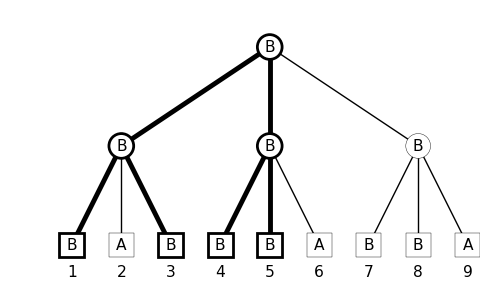

In [15]:
#
# Draw TPT tree
#

"Draw the TPT tree for a contest using PyPlot"            
function draw_tree(contest)
    pygui(false)       # draw in notebook instead of separate window
    fig, ax = PyPlot.subplots(figsize=(5,4))
    ax.axis("off")
    PyPlot.tight_layout()
    xlim(-5, 10 * contest.k ^ depth(contest.nt, contest.k))
    ylim(-5, 20 * depth(contest.nt, contest.k)+10)
    ax.set_aspect("equal")
    tree = contest.tree
    fontsize = 100 / contest.k ^ depth(contest.nt, contest.k)
    for i in 1:contest.nt
        tree[i].y = (depth(contest.nt, contest.k)-depth(i, contest.k)) * 20
        tree[i].x = (tree[i].index-0.5) * 10 * 
                    contest.k^(depth(contest.nt,contest.k)-depth(i, contest.k))  
        linewidth = tree[i].audit==1 ? 2 : 0.3
        if i>contest.ni
            # leaf (square)
            rect = matplotlib.patches.Rectangle(
            (tree[i].x, tree[i].y),5,5,
            linewidth=linewidth,edgecolor="k",facecolor="w")
            ax.add_patch(rect)
            ax.text(tree[i].x+2.5, tree[i].y+2.5,
                string(tree[i].val),
                fontsize=fontsize,
                horizontalalignment="center",
                verticalalignment="center")
            ax.text(tree[i].x+2.5, tree[i].y-3,
                i-contest.ni,
                fontsize=fontsize,
                horizontalalignment="center",
                verticalalignment="center")
        else
            # internal node (circle)
            circ = matplotlib.patches.Circle(
                (tree[i].x+2.5, tree[i].y+2.5),
                linewidth=linewidth,
                radius = 2.5, facecolor="w", edgecolor="k")
            ax.add_patch(circ)
            ax.text(tree[i].x+2.5, tree[i].y+2.5,
                string(tree[i].val),
                fontsize=fontsize,
                horizontalalignment="center",
                verticalalignment="center")
        end
        if i>1 
            # draw edge from parent
            xs = (tree[i].x+2.5, tree[parent(i, contest.k)].x+2.5)
            ys = (tree[i].y+2.5, tree[parent(i, contest.k)].y+2.5)
            linewidth = tree[i].audit ? 3.5 : 1
            # note use of zorder in next line to hide segment ends
            ax.plot(xs, ys, marker = "o", 
                color="k", linewidth=linewidth, zorder=0)
        end
    end
end

            
vals = collect("ABABABBBB")                           
contest = make_contest(vals, vals, seed=8)
tabulate!(contest)
mark_audit!(contest)
draw_tree(contest)
savefig("basic_fig.svg")
# show()

In [11]:
#
# Compute probability that TPT winner is plurality winner
#

"Return list of all length-k combinations of elements from 1:m"
# combinations(4, 3) 
# ==> [(1,1,1), (1,1,2), ..., (4,4,4)]  (64 elements)
function combinations(m, k)
    reverse.(Iterators.product(fill(1:m,k)...))[:]
end


"Compute probability of each outcome through one k-ary plurality node"
function prob_outcomes(pi, k=3)
    # pi = [...] giving input probability of candidates 1...m
    # k = arity of node (number of children)
    m = length(pi)
    comb = combinations(m, k)
    po = fill(0.0, m)
    for c in comb
        pcomb = prod(pi[collect(c)])  # probability of this input combination
        winners = plurality_winners(collect(c))
        for w in winners
            po[w] += pcomb / length(winners)
        end
    end
    return po
end


function California()
    println("California 2016 Presidential Election")
    println("Probability of a node at given height having given winner")
    println("  Height   Clinton        Trump    Other")
    p = [0.6173, 0.3162, 0.0665]  # California: Clinton / Trump / Other  from 2016
    for i in 0:15
        printfmt("    {:6s}  {:10.7f} {:10.7f} {:10.7f}\n", i, p[1], p[2], p[3])
        p = prob_outcomes(p)
    end
    println()
end

California()


function Michigan()
    println("Michigan 2016 Presidential Election")
    println("Probability of a node at given height having given winner")
    println("  Height     Trump      Clinton    Other")
    p = [0.4750, 0.4727, 0.0523]  # Michigan: Trump / Clinton / Other  from 2016
    for i in 0:19
        printfmt("    {:6s}  {:10.7f} {:10.7f} {:10.7f}\n", i, p[1], p[2], p[3])
        p = prob_outcomes(p)
    end
    println()
end

Michigan()


California 2016 Presidential Election
Probability of a node at given height having given winner
  Height   Clinton        Trump    Other
    0        0.6173000  0.3162000  0.0665000
    1        0.6986824  0.2626787  0.0386389
    2        0.7965204  0.1849333  0.0185462
    3        0.8981017  0.0954153  0.0064830
    4        0.9720774  0.0266860  0.0012366
    5        0.9977687  0.0021626  0.0000687
    6        0.9999854  0.0000143  0.0000003
    7        1.0000000  0.0000000  0.0000000
    8        1.0000000  0.0000000  0.0000000
    9        1.0000000  0.0000000  0.0000000
    10       1.0000000  0.0000000  0.0000000
    11       1.0000000  0.0000000  0.0000000
    12       1.0000000  0.0000000  0.0000000
    13       1.0000000  0.0000000  0.0000000
    14       1.0000000  0.0000000  0.0000000
    15       1.0000000  0.0000000  0.0000000

Michigan 2016 Presidential Election
Probability of a node at given height having given winner
  Height     Trump      Clinton    Other
    0  